In [3]:

# Dataset: Twitter Climate Change Sentiment Dataset (43,943 tweets)
# Models: Multilingual BERT + PEGASUS
# ============================================================================

# ============================================================================
# STEP 1: INSTALL DEPENDENCIES
# ============================================================================

!pip install -q kagglehub transformers datasets torch sentencepiece sacremoses \
    bertviz scikit-learn matplotlib seaborn plotly pandas numpy accelerate

print("✅ All dependencies installed!")

# ============================================================================
# STEP 2: MOUNT GOOGLE DRIVE
# ============================================================================

from google.colab import drive
drive.mount('/content/drive')

import os
import warnings
warnings.filterwarnings('ignore')

# Create directory structure
CONFIG = {
    'drive_path': '/content/drive/MyDrive/ClimateNLP',
    'model_save_path': '/content/drive/MyDrive/ClimateNLP/models',
    'results_path': '/content/drive/MyDrive/ClimateNLP/results',
    'data_path': '/content/drive/MyDrive/ClimateNLP/data',
    'max_length': 128,
    'batch_size': 16,
    'epochs': 3,
    'learning_rate': 2e-5,
}

for path in CONFIG.values():
    if isinstance(path, str) and path.startswith('/content/drive'):
        os.makedirs(path, exist_ok=True)

print(f"✅ Directory structure created in Google Drive")

# =============================================================

✅ All dependencies installed!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Directory structure created in Google Drive


In [4]:
# STEP 3: DOWNLOAD DATASET WITH KAGGLEHUB
# ============================================================================

import kagglehub
from google.colab import files

print("\n" + "="*70)
print("📥 KAGGLE AUTHENTICATION")
print("="*70)
print("\n1. Go to https://www.kaggle.com/settings")
print("2. Scroll to 'API' section")
print("3. Click 'Create New Token'")
print("4. Upload the downloaded kaggle.json file below\n")

# Upload kaggle.json
uploaded = files.upload()

# Setup Kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("\n✅ Kaggle authentication complete!")

# Download the dataset
print("\n" + "="*70)
print("⬇️ DOWNLOADING DATASET")
print("="*70)

path = kagglehub.dataset_download("edqian/twitter-climate-change-sentiment-dataset")
print(f"\n✅ Dataset downloaded to: {path}")

# List downloaded files
files_list = os.listdir(path)
print(f"📁 Files: {files_list}")




📥 KAGGLE AUTHENTICATION

1. Go to https://www.kaggle.com/settings
2. Scroll to 'API' section
3. Click 'Create New Token'
4. Upload the downloaded kaggle.json file below



Saving kaggle.json to kaggle.json

✅ Kaggle authentication complete!

⬇️ DOWNLOADING DATASET


100%|██████████| 2.46M/2.46M [00:00<00:00, 142MB/s]

Extracting files...

✅ Dataset downloaded to: /root/.cache/kagglehub/datasets/edqian/twitter-climate-change-sentiment-dataset/versions/1
📁 Files: ['twitter_sentiment_data.csv']


In [6]:


# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*70)
print("📊 LOADING & EXPLORING DATA")
print("="*70)

# Find and load CSV file
csv_file = [f for f in files_list if f.endswith('.csv')][0]
dataset_path = os.path.join(path, csv_file)

# Load dataset (encoding handles special characters in tweets)
df_raw = pd.read_csv(dataset_path, encoding='ISO-8859-1')

print(f"\n✅ Dataset loaded successfully!")
print(f"   Shape: {df_raw.shape}")
print(f"   Columns: {df_raw.columns.tolist()}")

# Display basic info
print("\n📋 Dataset Info:")
print(df_raw.info())

print("\n🔍 First 5 rows:")
print(df_raw.head())

# Check for missing values
print(f"\n❓ Missing values:")
print(df_raw.isnull().sum())

# Sentiment distribution
print("\n" + "="*70)
print("📈 SENTIMENT DISTRIBUTION")
print("="*70)

sentiment_counts = df_raw['sentiment'].value_counts().sort_index()
print("\nSentiment breakdown:")
print(f"  -1 (Anti - Climate Denial): {sentiment_counts.get(-1, 0):,}")
print(f"   0 (Neutral): {sentiment_counts.get(0, 0):,}")
print(f"   1 (Pro - Believes Climate Change): {sentiment_counts.get(1, 0):,}")
print(f"   2 (News - Factual): {sentiment_counts.get(2, 0):,}")
print(f"\n  Total: {len(df_raw):,} tweets")




📊 LOADING & EXPLORING DATA

✅ Dataset loaded successfully!
   Shape: (43943, 3)
   Columns: ['sentiment', 'message', 'tweetid']

📋 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43943 entries, 0 to 43942
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  43943 non-null  int64 
 1   message    43943 non-null  object
 2   tweetid    43943 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.0+ MB
None

🔍 First 5 rows:
   sentiment                                            message  \
0         -1  @tiniebeany climate change is an interesting h...   
1          1  RT @NatGeoChannel: Watch #BeforeTheFlood right...   
2          1  Fabulous! Leonardo #DiCaprio's film on #climat...   
3          1  RT @Mick_Fanning: Just watched this amazing do...   
4          2  RT @cnalive: Pranita Biswasi, a Lutheran from ...   

              tweetid  
0  792927353886371840  
1  793124211518832641  
2  7


✅ Visualization saved to: /content/drive/MyDrive/ClimateNLP/results/sentiment_distribution.png


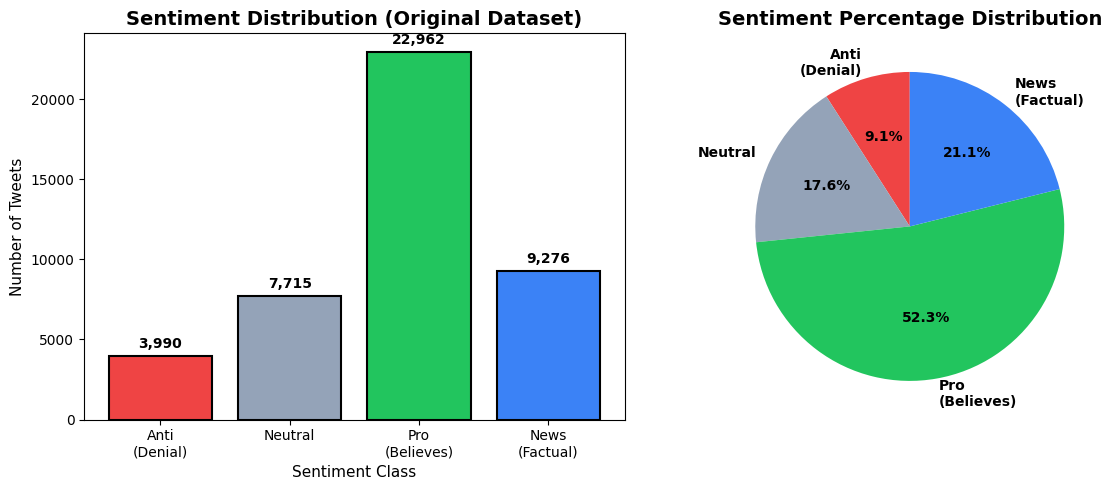

In [7]:
# Visualize distribution
plt.figure(figsize=(12, 5))

# Subplot 1: Count plot
plt.subplot(1, 2, 1)
sentiment_labels = {-1: 'Anti\n(Denial)', 0: 'Neutral', 1: 'Pro\n(Believes)', 2: 'News\n(Factual)'}
counts = df_raw['sentiment'].value_counts().sort_index()
colors = ['#ef4444', '#94a3b8', '#22c55e', '#3b82f6']
plt.bar([sentiment_labels[k] for k in counts.index], counts.values, color=colors, edgecolor='black', linewidth=1.5)
plt.title('Sentiment Distribution (Original Dataset)', fontsize=14, fontweight='bold')
plt.ylabel('Number of Tweets', fontsize=11)
plt.xlabel('Sentiment Class', fontsize=11)

# Add count labels on bars
for i, (idx, val) in enumerate(counts.items()):
    plt.text(i, val + 500, f'{val:,}', ha='center', fontsize=10, fontweight='bold')

# Subplot 2: Pie chart
plt.subplot(1, 2, 2)
plt.pie(counts.values, labels=[sentiment_labels[k] for k in counts.index],
        autopct='%1.1f%%', colors=colors, startangle=90, textprops={'fontsize': 10, 'fontweight': 'bold'})
plt.title('Sentiment Percentage Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(f"{CONFIG['results_path']}/sentiment_distribution.png", dpi=300, bbox_inches='tight')
print(f"\n✅ Visualization saved to: {CONFIG['results_path']}/sentiment_distribution.png")
plt.show()

# ===========================================


🔧 CREATING BINARY CLASSIFICATION DATASET

🧹 Cleaning data...
   Removed 2,911 low-quality tweets
   Final dataset size: 41,032 tweets

📊 BINARY CLASSIFICATION DISTRIBUTION

✅ Credible Information (label=0): 29,672
⚠️  Misinformation/Questionable (label=1): 11,360
   Balance ratio: 2.61:1

✅ Binary distribution saved


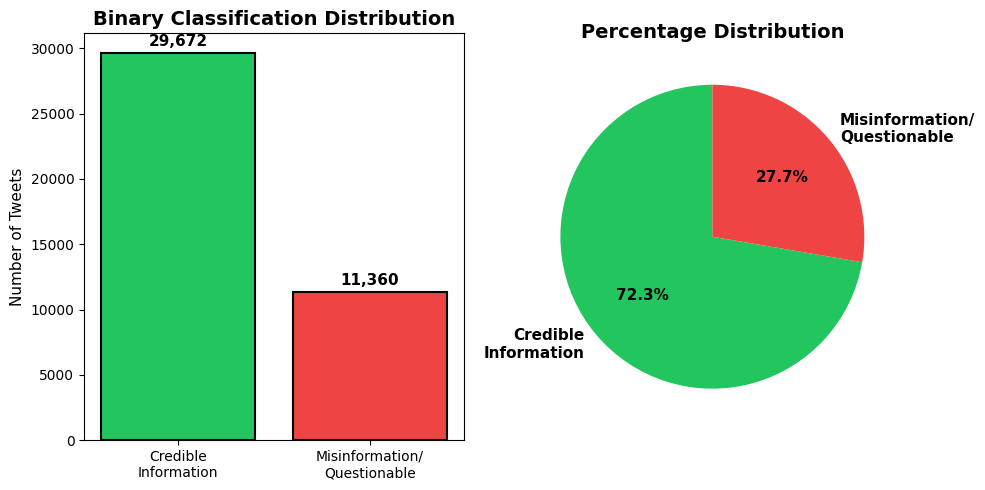


🔍 SAMPLE TWEETS

✅ CREDIBLE INFORMATION (label=0):
   1. RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world to tackle climate change https://...
   2. Fabulous! Leonardo #DiCaprio's film on #climate change is brilliant!!! Do watch. https://t.co/7rV6BrmxjW via @youtube...
   3. RT @Mick_Fanning: Just watched this amazing documentary by leonardodicaprio on climate change. We all think thisÃÂ¢Ã¢â...

⚠️  MISINFORMATION/QUESTIONABLE (label=1):
   1. @tiniebeany climate change is an interesting hustle as it was global warming but the planet stopped warming for 15 yes w...
   2. Unamshow awache kujinga na iko global warming https://t.co/mhIflU7M1X...
   3. RT @AmericanIndian8: Leonardo DiCaprio's climate change documentary is free for a week https://t.co/ITpdZ6kCeg
#INDIGENO...


In [8]:
# STEP 5: PREPROCESS FOR BINARY CLASSIFICATION (MISINFORMATION DETECTION)
# ============================================================================

print("\n" + "="*70)
print("🔧 CREATING BINARY CLASSIFICATION DATASET")
print("="*70)

# Binary classification strategy:
# Label 0 (CREDIBLE): Pro (1) + News (2) - Aligned with climate science
# Label 1 (MISINFORMATION): Anti (-1) + Neutral (0) - Denial or questionable

def create_binary_labels(sentiment):
    """
    Map 4-class sentiment to binary misinformation labels
    0 = Credible information (Pro/News)
    1 = Misinformation/Questionable (Anti/Neutral)
    """
    if sentiment in [1, 2]:  # Pro or News
        return 0  # Credible
    else:  # Anti or Neutral
        return 1  # Misinformation/Questionable

# Create processed dataset
df_processed = pd.DataFrame({
    'text': df_raw['message'].astype(str),
    'sentiment_original': df_raw['sentiment'],
    'label': df_raw['sentiment'].apply(create_binary_labels),
    'language': 'en'
})

# Clean data
print("\n🧹 Cleaning data...")
initial_count = len(df_processed)

# Remove nulls
df_processed = df_processed.dropna(subset=['text'])

# Remove empty strings
df_processed = df_processed[df_processed['text'].str.strip() != '']

# Remove duplicates
df_processed = df_processed.drop_duplicates(subset=['text'])

# Remove very short tweets (likely not informative)
df_processed = df_processed[df_processed['text'].str.len() > 10]

final_count = len(df_processed)
print(f"   Removed {initial_count - final_count:,} low-quality tweets")
print(f"   Final dataset size: {final_count:,} tweets")

# Show binary distribution
print("\n" + "="*70)
print("📊 BINARY CLASSIFICATION DISTRIBUTION")
print("="*70)

binary_counts = df_processed['label'].value_counts()
print(f"\n✅ Credible Information (label=0): {binary_counts.get(0, 0):,}")
print(f"⚠️  Misinformation/Questionable (label=1): {binary_counts.get(1, 0):,}")
print(f"   Balance ratio: {binary_counts.get(0, 0) / binary_counts.get(1, 0):.2f}:1")

# Visualize binary distribution
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
labels_binary = ['Credible\nInformation', 'Misinformation/\nQuestionable']
colors_binary = ['#22c55e', '#ef4444']
plt.bar(labels_binary, binary_counts.values, color=colors_binary, edgecolor='black', linewidth=1.5)
plt.title('Binary Classification Distribution', fontsize=14, fontweight='bold')
plt.ylabel('Number of Tweets', fontsize=11)
for i, val in enumerate(binary_counts.values):
    plt.text(i, val + 500, f'{val:,}', ha='center', fontsize=11, fontweight='bold')

plt.subplot(1, 2, 2)
plt.pie(binary_counts.values, labels=labels_binary, autopct='%1.1f%%',
        colors=colors_binary, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
plt.title('Percentage Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(f"{CONFIG['results_path']}/binary_distribution.png", dpi=300, bbox_inches='tight')
print(f"\n✅ Binary distribution saved")
plt.show()

# Sample tweets
print("\n" + "="*70)
print("🔍 SAMPLE TWEETS")
print("="*70)

print("\n✅ CREDIBLE INFORMATION (label=0):")
for i, text in enumerate(df_processed[df_processed['label'] == 0]['text'].head(3), 1):
    print(f"   {i}. {text[:120]}...")

print("\n⚠️  MISINFORMATION/QUESTIONABLE (label=1):")
for i, text in enumerate(df_processed[df_processed['label'] == 1]['text'].head(3), 1):
    print(f"   {i}. {text[:120]}...")

In [9]:

# Save processed dataset
df_processed.to_csv(f"{CONFIG['data_path']}/misinformation_dataset.csv", index=False)
print(f"\n💾 Processed dataset saved to: {CONFIG['data_path']}/misinformation_dataset.csv")



💾 Processed dataset saved to: /content/drive/MyDrive/ClimateNLP/data/misinformation_dataset.csv


In [10]:
# STEP 6: LOAD MULTILINGUAL BERT MODEL
# ============================================================================

import torch
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, EarlyStoppingCallback
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

print("\n" + "="*70)
print("🤖 LOADING MULTILINGUAL BERT MODEL")
print("="*70)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n🖥️  Device: {device}")
if device.type == 'cuda':
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Load multilingual BERT (supports 104 languages)
model_name = "bert-base-multilingual-cased"
print(f"\n⬇️  Loading {model_name}...")

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    problem_type="single_label_classification"
).to(device)

print(f"✅ Model loaded successfully!")
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")



🤖 LOADING MULTILINGUAL BERT MODEL

🖥️  Device: cuda
   GPU: Tesla T4
   Memory: 15.83 GB

⬇️  Loading bert-base-multilingual-cased...


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded successfully!
   Parameters: 177,854,978


In [14]:

# ============================================================================

print("\n" + "="*70)
print("📋 PREPARING TRAINING DATA")
print("="*70)

# Split data
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df_processed['text'].tolist(),
    df_processed['label'].tolist(),
    test_size=0.3,
    random_state=42,
    stratify=df_processed['label']
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,
    random_state=42,
    stratify=temp_labels
)

print(f"\n✅ Data split complete:")
print(f"   Training samples: {len(train_texts):,}")
print(f"   Validation samples: {len(val_texts):,}")
print(f"   Test samples: {len(test_texts):,}")

# Tokenize data
print(f"\n🔤 Tokenizing data...")

train_encodings = tokenizer(
    train_texts,
    truncation=True,
    padding=True,
    max_length=CONFIG['max_length'],
    return_tensors='pt'
)

val_encodings = tokenizer(
    val_texts,
    truncation=True,
    padding=True,
    max_length=CONFIG['max_length'],
    return_tensors='pt'
)

test_encodings = tokenizer(
    test_texts,
    truncation=True,
    padding=True,
    max_length=CONFIG['max_length'],
    return_tensors='pt'
)

print(f"✅ Tokenization complete")

# Create PyTorch datasets
class ClimateDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ClimateDataset(train_encodings, train_labels)
val_dataset = ClimateDataset(val_encodings, val_labels)
test_dataset = ClimateDataset(test_encodings, test_labels)

print(f"✅ Datasets created")



📋 PREPARING TRAINING DATA

✅ Data split complete:
   Training samples: 28,722
   Validation samples: 6,155
   Test samples: 6,155

🔤 Tokenizing data...
✅ Tokenization complete
✅ Datasets created


In [15]:
# STEP 8: DEFINE TRAINING CONFIGURATION
# ============================================================================

print("\n" + "="*70)
print("⚙️  TRAINING CONFIGURATION")
print("="*70)

def compute_metrics(eval_pred):
    """Compute evaluation metrics"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='binary', zero_division=0
    )

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Training arguments
training_args = TrainingArguments(
    output_dir=f"{CONFIG['model_save_path']}/checkpoints",
    num_train_epochs=CONFIG['epochs'],
    per_device_train_batch_size=CONFIG['batch_size'],
    per_device_eval_batch_size=CONFIG['batch_size'],
    learning_rate=CONFIG['learning_rate'],
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir=f"{CONFIG['results_path']}/logs",
    logging_steps=100,
    eval_strategy="steps",
    eval_steps=200,
    save_strategy="steps",
    save_steps=200,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),  # Use mixed precision if GPU available
    report_to="none",
    remove_unused_columns=True,
)

print(f"\n📝 Training configuration:")
print(f"   Epochs: {CONFIG['epochs']}")
print(f"   Batch size: {CONFIG['batch_size']}")
print(f"   Learning rate: {CONFIG['learning_rate']}")
print(f"   Max sequence length: {CONFIG['max_length']}")
print(f"   Mixed precision (FP16): {training_args.fp16}")

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

print(f"✅ Trainer initialized")


⚙️  TRAINING CONFIGURATION

📝 Training configuration:
   Epochs: 3
   Batch size: 16
   Learning rate: 2e-05
   Max sequence length: 128
   Mixed precision (FP16): True
✅ Trainer initialized


In [16]:
# STEP 9: TRAIN THE MODEL
# ============================================================================

print("\n" + "="*70)
print("🏋️ TRAINING MISINFORMATION DETECTION MODEL")
print("="*70)
print("\n🚀 Training started...\n")

# Train
train_result = trainer.train()

print("\n" + "="*70)
print("✅ TRAINING COMPLETE!")
print("="*70)

# Print training metrics
print(f"\n📊 Training metrics:")
for key, value in train_result.metrics.items():
    print(f"   {key}: {value:.4f}")

# ============================================================================
# STEP 10: EVALUATE ON VALIDATION SET
# ============================================================================

print("\n" + "="*70)
print("📈 VALIDATION SET EVALUATION")
print("="*70)

eval_results = trainer.evaluate()

print(f"\n✅ Validation results:")
for key, value in eval_results.items():
    if isinstance(value, float):
        print(f"   {key}: {value:.4f}")


🏋️ TRAINING MISINFORMATION DETECTION MODEL

🚀 Training started...



Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,0.533700,0.545318,0.748822,0.707895,0.157864,0.258157
400,0.494800,0.484601,0.770106,0.763206,0.245892,0.371949
600,0.478400,0.501817,0.800650,0.692184,0.504108,0.583362
800,0.454500,0.431503,0.802112,0.768212,0.408451,0.533333
1000,0.423600,0.436908,0.798538,0.613949,0.733568,0.668449
1200,0.410400,0.544911,0.800650,0.845152,0.342723,0.487683
1400,0.387000,0.388274,0.820634,0.753378,0.523474,0.617729
1600,0.408400,0.376586,0.828270,0.711576,0.638498,0.673059
1800,0.380500,0.381460,0.830869,0.745011,0.591549,0.659470
2000,0.318800,0.401153,0.833306,0.765674,0.573357,0.655705



✅ TRAINING COMPLETE!

📊 Training metrics:
   train_runtime: 1360.2214
   train_samples_per_second: 63.3470
   train_steps_per_second: 3.9610
   total_flos: 4628912796948480.0000
   train_loss: 0.3460
   epoch: 2.4499

📈 VALIDATION SET EVALUATION



✅ Validation results:
   eval_loss: 0.4491
   eval_accuracy: 0.8435
   eval_precision: 0.7087
   eval_recall: 0.7383
   eval_f1: 0.7232
   eval_runtime: 12.4735
   eval_samples_per_second: 493.4460
   eval_steps_per_second: 30.8650
   epoch: 2.4499



🧪 TEST SET EVALUATION



✅ Test set results:
   Accuracy: 0.8492
   Precision: 0.7130
   Recall: 0.7623
   F1 Score: 0.7368

📋 Detailed classification report:
                precision    recall  f1-score   support

      Credible       0.91      0.88      0.89      4451
Misinformation       0.71      0.76      0.74      1704

      accuracy                           0.85      6155
     macro avg       0.81      0.82      0.82      6155
  weighted avg       0.85      0.85      0.85      6155


✅ Confusion matrix saved


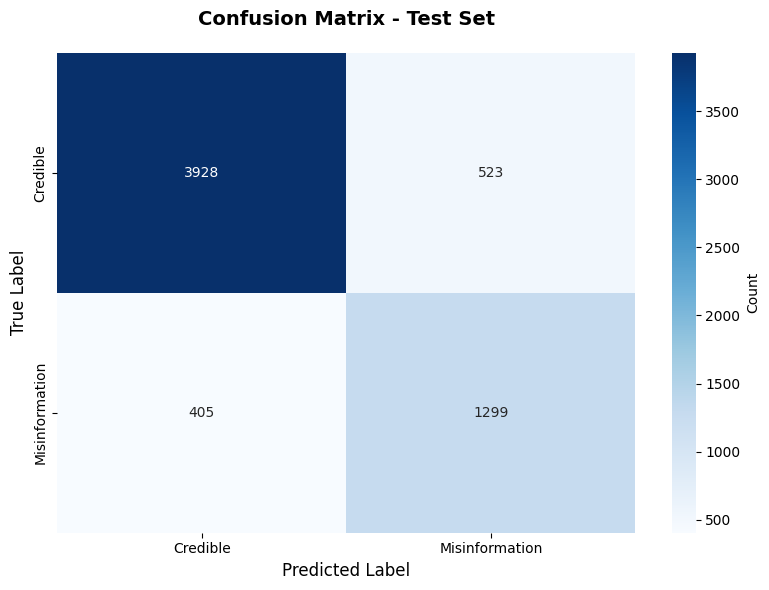

In [18]:

# ============================================================================

print("\n" + "="*70)
print("🧪 TEST SET EVALUATION")
print("="*70)

# Get predictions
test_predictions = trainer.predict(test_dataset)
test_pred_labels = np.argmax(test_predictions.predictions, axis=-1)

# Compute metrics
test_accuracy = accuracy_score(test_labels, test_pred_labels)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
    test_labels, test_pred_labels, average='binary', zero_division=0
)

print(f"\n✅ Test set results:")
print(f"   Accuracy: {test_accuracy:.4f}")
print(f"   Precision: {test_precision:.4f}")
print(f"   Recall: {test_recall:.4f}")
print(f"   F1 Score: {test_f1:.4f}")

# Classification report
print(f"\n📋 Detailed classification report:")
class_names = ['Credible', 'Misinformation']
print(classification_report(test_labels, test_pred_labels, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(test_labels, test_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig(f"{CONFIG['results_path']}/confusion_matrix_test.png", dpi=300, bbox_inches='tight')
print(f"\n✅ Confusion matrix saved")
plt.show()


In [19]:
# STEP 12: SAVE MODEL
# ============================================================================

print("\n" + "="*70)
print("💾 SAVING MODEL")
print("="*70)

model_save_path = f"{CONFIG['model_save_path']}/misinformation_detector"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"\n✅ Model saved to: {model_save_path}")

# Save evaluation results
import json

evaluation_results = {
    'model': model_name,
    'dataset': 'Twitter Climate Change Sentiment Dataset',
    'total_samples': len(df_processed),
    'train_samples': len(train_texts),
    'val_samples': len(val_texts),
    'test_samples': len(test_texts),
    'test_metrics': {
        'accuracy': float(test_accuracy),
        'precision': float(test_precision),
        'recall': float(test_recall),
        'f1_score': float(test_f1)
    },
    'confusion_matrix': cm.tolist(),
    'training_time': str(train_result.metrics.get('train_runtime', 0)) + ' seconds',
    'config': CONFIG
}

with open(f"{CONFIG['results_path']}/evaluation_results.json", 'w') as f:
    json.dump(evaluation_results, f, indent=2)

print(f"✅ Evaluation results saved")



💾 SAVING MODEL

✅ Model saved to: /content/drive/MyDrive/ClimateNLP/models/misinformation_detector
✅ Evaluation results saved


In [20]:
# STEP 13: TEST MODEL WITH EXAMPLES
# ============================================================================

print("\n" + "="*70)
print("🧪 TESTING WITH REAL EXAMPLES")
print("="*70)

from transformers import pipeline

# Create classification pipeline
classifier = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=0 if device.type == 'cuda' else -1
)

test_examples = [
    "Climate change is a hoax created by scientists for funding",
    "The IPCC report confirms global temperatures have risen 1.1°C",
    "CO2 is plant food, more CO2 is actually good for the planet",
    "Renewable energy is essential for reducing greenhouse gas emissions",
    "Global warming stopped in 1998 and hasn't continued since",
    "Arctic ice is melting at an unprecedented rate due to human activity"
]

print("\n🔍 Testing on example tweets:\n")

for i, text in enumerate(test_examples, 1):
    result = classifier(text)[0]
    label = "✅ CREDIBLE" if result['label'] == 'LABEL_0' else "⚠️ MISINFORMATION"
    confidence = result['score'] * 100

    print(f"{i}. {text[:80]}...")
    print(f"   → {label} (confidence: {confidence:.1f}%)\n")

# ===================================

Device set to use cuda:0



🧪 TESTING WITH REAL EXAMPLES

🔍 Testing on example tweets:

1. Climate change is a hoax created by scientists for funding...
   → ✅ CREDIBLE (confidence: 54.1%)

2. The IPCC report confirms global temperatures have risen 1.1°C...
   → ✅ CREDIBLE (confidence: 97.9%)

3. CO2 is plant food, more CO2 is actually good for the planet...
   → ✅ CREDIBLE (confidence: 99.5%)

4. Renewable energy is essential for reducing greenhouse gas emissions...
   → ✅ CREDIBLE (confidence: 99.6%)

5. Global warming stopped in 1998 and hasn't continued since...
   → ⚠️ MISINFORMATION (confidence: 98.6%)

6. Arctic ice is melting at an unprecedented rate due to human activity...
   → ✅ CREDIBLE (confidence: 99.5%)



In [21]:
# STEP 14: POLICY SUMMARIZATION MODEL
# ============================================================================

print("\n" + "="*70)
print("📝 LOADING POLICY SUMMARIZATION MODEL")
print("="*70)

from transformers import AutoModelForSeq2SeqLM

# Load PEGASUS for summarization
sum_model_name = "google/pegasus-xsum"
print(f"\n⬇️  Loading {sum_model_name}...")

tokenizer_sum = AutoTokenizer.from_pretrained(sum_model_name)
model_sum = AutoModelForSeq2SeqLM.from_pretrained(sum_model_name).to(device)

print(f"✅ Summarization model loaded!")

# Sample policy documents
policy_docs = [
    """The Paris Agreement is a legally binding international treaty on climate change adopted by 196 Parties at COP 21 in Paris on 12 December 2015. Its goal is to limit global warming to well below 2, preferably to 1.5 degrees Celsius, compared to pre-industrial levels. To achieve this long-term temperature goal, countries aim to reach global peaking of greenhouse gas emissions as soon as possible to achieve a climate neutral world by mid-century. The Paris Agreement works on a 5-year cycle of increasingly ambitious climate action carried out by countries. Every five years, each country is expected to submit an updated national climate action plan, known as Nationally Determined Contributions (NDCs). In their NDCs, countries communicate actions they will take to reduce their Greenhouse Gas emissions in order to reach the goals of the Paris Agreement.""",

    """The European Green Deal is the European Union's response to the climate and environmental challenges that are the defining task of this generation. It is a new growth strategy that aims to transform the EU into a modern, resource-efficient and competitive economy where there are no net emissions of greenhouse gases by 2050, economic growth is decoupled from resource use, and no person and no place is left behind. The European Climate Law enshrines the 2050 climate neutrality target into binding EU legislation. The Green Deal covers all sectors of the economy, notably transport, energy, agriculture, buildings, and industries such as steel, cement, ICT, textiles and chemicals. It provides a roadmap with actions to boost the efficient use of resources by moving to a clean, circular economy and stop climate change, revert biodiversity loss and cut pollution."""
]

print("\n" + "="*70)
print("📄 GENERATING POLICY SUMMARIES")
print("="*70)

summaries = []

for i, doc in enumerate(policy_docs, 1):
    print(f"\n📄 Document {i} ({len(doc.split())} words):")
    print(f"   {doc[:100]}...")

    inputs = tokenizer_sum(doc, max_length=1024, truncation=True, return_tensors="pt").to(device)

    with torch.no_grad():
        summary_ids = model_sum.generate(
            inputs["input_ids"],
            max_length=150,
            min_length=40,
            num_beams=4,
            length_penalty=2.0,
            early_stopping=True,
            no_repeat_ngram_size=3
        )

    summary = tokenizer_sum.decode(summary_ids[0], skip_special_tokens=True)
    summaries.append(summary)

    print(f"\n   ✅ Summary ({len(summary.split())} words):")
    print(f"   {summary}\n")



📝 LOADING POLICY SUMMARIZATION MODEL

⬇️  Loading google/pegasus-xsum...


tokenizer_config.json:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/259 [00:00<?, ?B/s]

✅ Summarization model loaded!

📄 GENERATING POLICY SUMMARIES

📄 Document 1 (136 words):
   The Paris Agreement is a legally binding international treaty on climate change adopted by 196 Parti...

   ✅ Summary (35 words):
   The Paris Agreement aims to limit global warming to well below 2C and to achieve a climate neutral world by mid-century, by limiting the rise in global temperatures to less than 2C above pre-industrial levels.


📄 Document 2 (137 words):
   The European Green Deal is the European Union's response to the climate and environmental challenges...

   ✅ Summary (48 words):
   The European Green Deal is a new growth strategy that aims to transform the EU into a modern, resource-efficient and competitive economy where there are no net emissions of greenhouse gases by 2050, economic growth is decoupled from resource use, and no person or place is left behind.



In [22]:
# Save summarization model
model_save_path_sum = f"{CONFIG['model_save_path']}/policy_summarizer"
model_sum.save_pretrained(model_save_path_sum)
tokenizer_sum.save_pretrained(model_save_path_sum)

print(f"✅ Summarization model saved to: {model_save_path_sum}")


✅ Summarization model saved to: /content/drive/MyDrive/ClimateNLP/models/policy_summarizer
